## 模型部署&推理
- 模型部署
- 模型推理
- 模型量化

我们会将PyTorch训练好的模型转换为ONNX 格式，然后使用ONNX Runtime运行它进行推理

### 1、ONNX
ONNX( Open Neural Network Exchange) 是 Facebook (现Meta) 和微软在2017年共同发布的，用于标准描述计算图的一种格式。ONNX通过定义一组与环境和平台无关的标准格式，使AI模型可以在不同框架和环境下交互使用，ONNX可以看作深度学习框架和部署端的桥梁，就像编译器的中间语言一样

由于各框架兼容性不一，我们通常只用 ONNX 表示更容易部署的静态图。硬件和软件厂商只需要基于ONNX标准优化模型性能，让所有兼容ONNX标准的框架受益

ONNX主要关注在模型预测方面，使用不同框架训练的模型，转化为ONNX格式后，可以很容易的部署在兼容ONNX的运行环境中

微软，亚马逊 ，Facebook(现Meta) 和 IBM 等公司和众多开源贡献的共同维护下，ONNX 已经对接了下图的多种深度学习框架和多种推理引擎

- ONNX官网：https://onnx.ai/
- ONNX GitHub：https://github.com/onnx/onnx

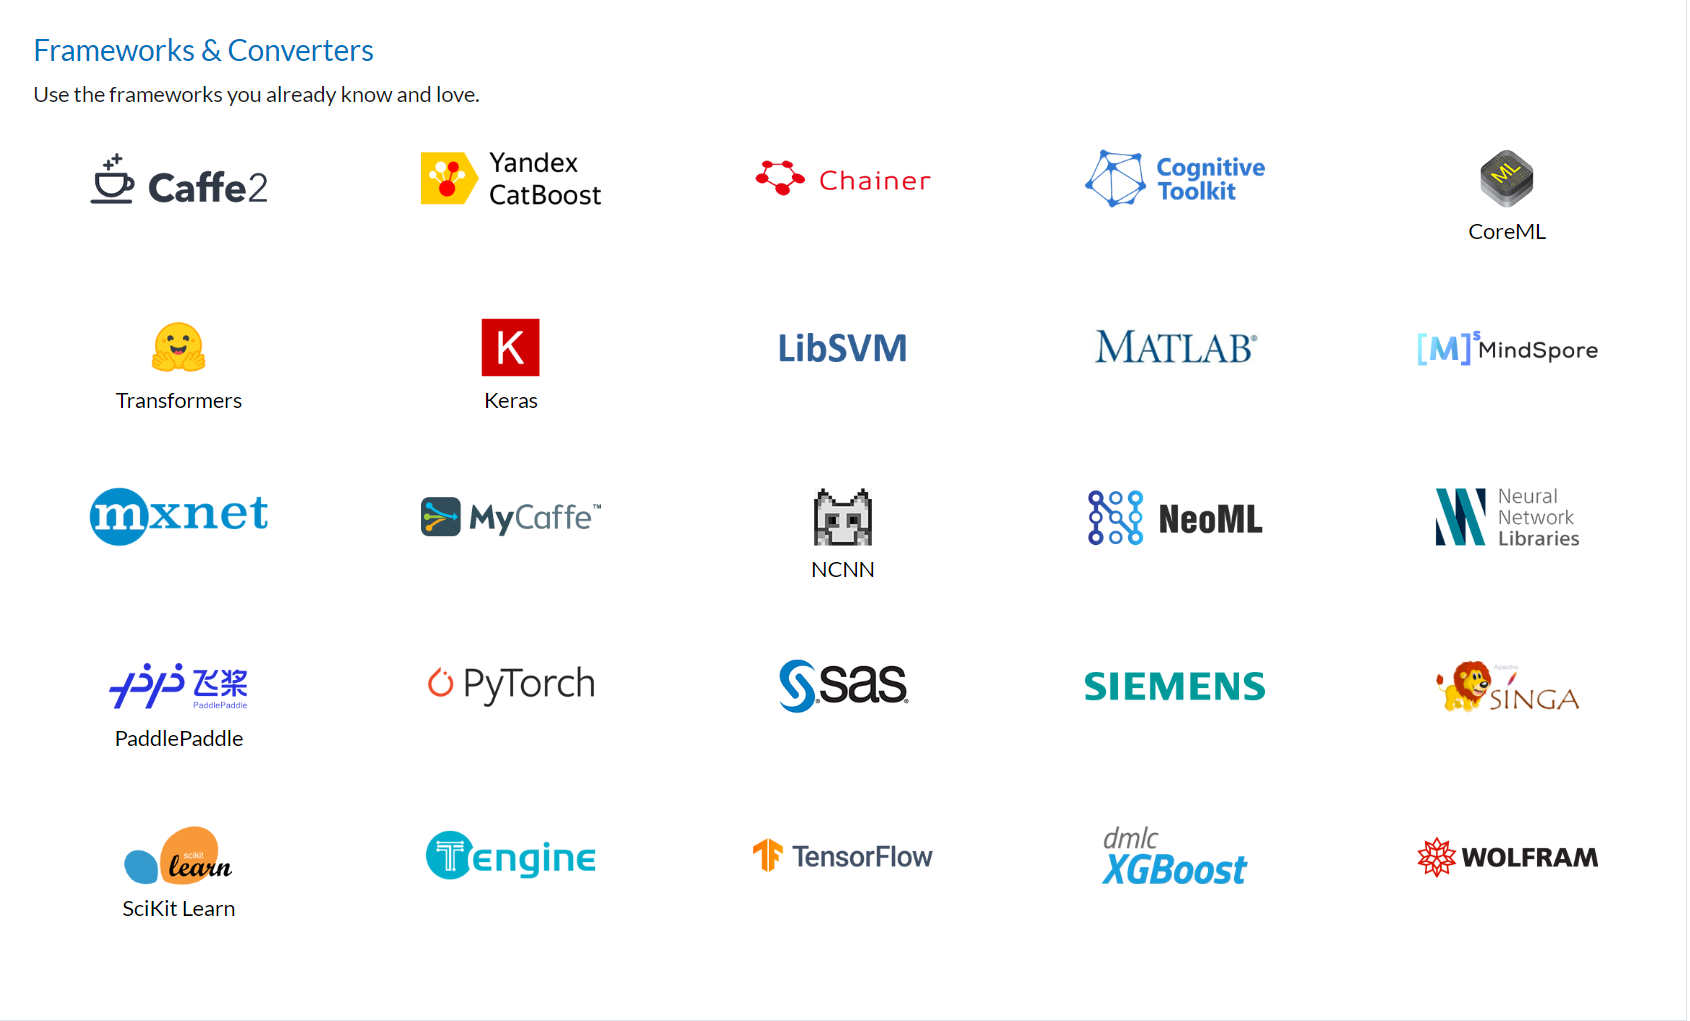



### 2、ONNX Runtime

- ONNX Runtime官网：https://www.onnxruntime.ai/
- ONNX Runtime GitHub：https://github.com/microsoft/onnxruntime

ONNX Runtime 是由微软维护的一个跨平台机器学习推理加速器，它直接对接ONNX，可以直接读取.onnx文件并实现推理，不需要再把 .onnx 格式的文件转换成其他格式的文件

PyTorch借助ONNX Runtime也完成了部署的最后一公里，构建了 PyTorch --> ONNX --> ONNX Runtime 部署流水线


# 安装onnx
pip install onnx 
# 安装onnx runtime
pip install onnxruntime # 使用CPU进行推理
# pip install onnxruntime-gpu # 使用GPU进行推理

注意：ONNX和ONNX Runtime之间的适配关系。我们可以访问ONNX Runtime的Github进行查看
网址：https://github.com/microsoft/onnxruntime/blob/master/docs/Versioning.md

ONNX Runtime和CUDA之间的适配关系
网址：https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html

### 模型转换为ONNX格式

- 用torch.onnx.export()把模型转换成 ONNX 格式的函数
- 模型导成onnx格式前，我们必须调用model.eval()或者model.train(False)以确保我们的模型处在推理模式下


In [ ]:
import torch.onnx 
# 转换的onnx格式的名称，文件后缀需为.onnx
onnx_file_name = "xxxxxx.onnx"
# 我们需要转换的模型，将torch_model设置为自己的模型
model = torch_model
# 加载权重，将model.pth转换为自己的模型权重
# 如果模型的权重是使用多卡训练出来，我们需要去除权重中多的module. 具体操作可以见5.4节
model = model.load_state_dict(torch.load("model.pth"))
# 导出模型前，必须调用model.eval()或者model.train(False)
model.eval()
# dummy_input就是一个输入的实例，仅提供输入shape、type等信息 
batch_size = 1 # 随机的取值，当设置dynamic_axes后影响不大
dummy_input = torch.randn(batch_size, 1, 224, 224, requires_grad=True) 
# 这组输入对应的模型输出
output = model(dummy_input)
# 导出模型
torch.onnx.export(model,        # 模型的名称
                  dummy_input,   # 一组实例化输入
                  onnx_file_name,   # 文件保存路径/名称
                  export_params=True,        #  如果指定为True或默认, 参数也会被导出. 如果你要导出一个没训练过的就设为 False.
                  opset_version=10,          # ONNX 算子集的版本，当前已更新到15
                  do_constant_folding=True,  # 是否执行常量折叠优化
                  input_names = ['input'],   # 输入模型的张量的名称
                  output_names = ['output'], # 输出模型的张量的名称
                  # dynamic_axes将batch_size的维度指定为动态，
                  # 后续进行推理的数据可以与导出的dummy_input的batch_size不同
                  dynamic_axes={'input' : {0 : 'batch_size'},    
                                'output' : {0 : 'batch_size'}})

In [ ]:
### ONNX模型的检验
# 我们需要检测下我们的模型文件是否可用，我们将通过onnx.checker.check_model()进行检验



In [ ]:
import onnx
# 我们可以使用异常处理的方法进行检验
try:
    # 当我们的模型不可用时，将会报出异常
    onnx.checker.check_model(self.onnx_model)
except onnx.checker.ValidationError as e:
    print("The model is invalid: %s"%e)
else:
    # 模型可用时，将不会报出异常，并会输出“The model is valid!”
    print("The model is valid!")